# **Imports**

In [30]:
#openCV
import cv2

#pandas
import pandas as pd

#numpy
import numpy as np

#maplotlib
from  matplotlib import pyplot as plt
%matplotlib inline

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#utils
import os
import random

print('[0] Imports done')

[0] Imports done


# **Data Preparation**

In [31]:
epochs = 2
lr = 1e-3
batch_size = 128
data = []
labels = []

In [32]:
size = 224 #height/width

# **Image Data Generator**

In [33]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   rescale=1/255)

In [34]:
test_gen = ImageDataGenerator(rescale=1/255)

In [35]:
target_size=(size,size)
target_size

(224, 224)

In [36]:
train_generator = train_datagen.flow_from_directory(
    directory='../input/gender-classification-dataset/Training',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 47009 images belonging to 2 classes.


In [37]:
validation_generator = test_gen.flow_from_directory(
    directory='../input/gender-classification-dataset/Validation',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 11649 images belonging to 2 classes.


In [38]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [39]:
len(train_generator.classes)

47009

In [40]:
train_generator.class_mode

'binary'

In [41]:
x,y = train_generator.next()

In [42]:
x[0].shape

(224, 224, 3)

In [43]:
x[0]

array([[[0.18039216, 0.04705883, 0.01176471],
        [0.18039216, 0.04705883, 0.01176471],
        [0.2901961 , 0.13725491, 0.10980393],
        ...,
        [0.10980393, 0.07450981, 0.05490196],
        [0.10980393, 0.07450981, 0.05490196],
        [0.10980393, 0.07450981, 0.05490196]],

       [[0.18039216, 0.04705883, 0.01176471],
        [0.18039216, 0.04705883, 0.01176471],
        [0.2901961 , 0.13725491, 0.10980393],
        ...,
        [0.10980393, 0.07450981, 0.05490196],
        [0.10980393, 0.07450981, 0.05490196],
        [0.10980393, 0.07450981, 0.05490196]],

       [[0.18039216, 0.04705883, 0.01176471],
        [0.18039216, 0.04705883, 0.01176471],
        [0.2890713 , 0.13633095, 0.10879962],
        ...,
        [0.10980393, 0.07450981, 0.05490196],
        [0.10980393, 0.07450981, 0.05490196],
        [0.10980393, 0.07450981, 0.05490196]],

       ...,

       [[0.87669754, 0.6505266 , 0.52330256],
        [0.8745099 , 0.654902  , 0.5254902 ],
        [0.8745099 , 0

# **Build Machine Learing Model**

In [44]:
model = Sequential()
model.add(InceptionV3(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable=False

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_190 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_191 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [46]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [47]:
len((train_generator.filenames)), batch_size, len((train_generator.filenames))//batch_size, epochs

(47009, 128, 367, 2)

In [48]:
model.fit(train_generator, 
          steps_per_epoch=len(train_generator.filenames)//batch_size,
          epochs=1,
          validation_data=validation_generator, 
          validation_steps=len(validation_generator.filenames)//batch_size
         )

367/367 [==============================] - 588s 2s/step - loss: 0.3620 - accuracy: 0.8538 - val_loss: 0.2176 - val_accuracy: 0.9141


# **Test Model**

In [49]:
img_path = '../input/gender-classification-dataset/Validation/female/112959.jpg.jpg'

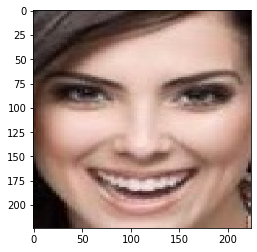

In [50]:
img = load_img(img_path, target_size=(size,size, 3))
plt.imshow(img)

In [51]:
img = img_to_array(img)

In [52]:
img = img/255.0

In [53]:
img = img.reshape(1, size, size, 3)

In [54]:
img.shape

(1, 224, 224, 3)

In [55]:
model.predict(img)

array([[0.01324076]], dtype=float32)

In [56]:
def get_classes(data):
    prob = model.predict(img)
    pred = np.argmax(prob, axis=1)

    if pred[0]==0:
        return 'female', (1 - prob[0][0])
    else:
        return 'male', prob[0][0]
    

In [57]:
get_classes(img)

('female', 0.9867592351511121)